<img src="OC.png" width="50" height="50" align="left">    

***

<center> <font size="6"> <span style='color:Blue'> P7: Implémentez un modèle de scoring </span></font> </center>  

***

<font size="3"> <span style="font-size: 1.5em" > **Partie 1 - 2/3: Réduction de dimensions des données** </span> </font> 

**Contexte**  
**Prêt à dépenser** est une société financière qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.
<img src="pretadepenser.png" width="200" height="200">
**Mission**   
* Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
* Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
* Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.

Dans ce notebook, nous allons appliquer l'ingénierie des variables au jeu de données obtenu dans le notebook précedent.

Nous allons réduire le nombre de variables en utilisant plusieurs méthodes, puis nous testerons les performances des vriables en utilisant un modèle de machine de boosting de gradient assez basique.

Les principales conclusions de ce notebook sont les suivantes:  

Passage de 797 fonctionnalités totales à **250** et un AUC ROC de validation croisée (cv=10) de **0.7904**.

L'ensemble complet de variables a été construit dans la partie 1.

Nous utiliserons trois méthodes de sélection de variables :

* Suppression des variables collinéaires.
* Suppression des variables avec un pourcentage de valeurs manquantes supérieur à un seuil.
* Ne conserver que les variables les plus pertinentes en utilisant les importances des fonctionnalités à partir d'un modèle.

Nous examinerons également un exemple d'application de l'ACP, bien que nous n'utiliserons pas cette méthode pour la réduction de dimension.

# Importation des données et des librairies Python pour DS

La préparation des données et features engineering sont effectuées sur la base du kernel Kaggle https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection

In [1]:
# ------------------------------------------
# Projet : Implémenter un modèle de scoring
# Données: https://www.kaggle.com/c/home-credit-default-risk/data
# Auteur : Rim BAHROUN
# Date: Avril 2023
# OpenClassrooms
# -------------------------------------------
# importation des librairies Python pour DS
# -------------------------------------------
import os
import csv
import numpy as np
import pandas as pd
import re
import gc
import time
import missingno as msno #missing data visualizations
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 800)

In [3]:
#num_rows = None  # 10000
train_df = pd.read_csv('data/traited/df_credit_train.csv')  # , nrows=num_rows
train_df = train_df.iloc[:,1:]
#test_df = pd.read_csv('data/traited/df_credit_test.csv', nrows=num_rows)
#test_df = test_df.iloc[:,1:]

In [4]:
print(train_df.shape)

(307507, 797)


In [4]:
train_df.head()

SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100002     1.0            0             0                0   
1      100003     0.0            1             0                1   
2      100004     0.0            0             1                0   
3      100006     0.0            1             0                0   
4      100007     0.0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   ...  CC_NAME_CONTRACT_STATUS_Signed_MAX  \
0  ...                                 NaN   
1  ...                                 NaN   
2  ...                                 NaN   
3  ...                                 0.0   
4  ...                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_MEAN  CC_NAME_CONTRACT_STATUS_Signed_SUM  \
0                                  NaN                                 NaN   
1                                  NaN                                 NaN   
2                                  NaN                                 NaN   
3                                  0.0                                 0.0   
4                                  NaN                                 NaN   

   CC_NAME_CONTRACT_STATUS_Signed_VAR  CC_NAME_CONTRACT_STATUS_nan_MIN  \
0                                 NaN                              NaN   
1                                 NaN                              NaN   
2                                 NaN                              NaN   
3                                 0.0                              0.0   
4                                 NaN                              NaN   

   CC_NAME_CONTRACT_STATUS_nan_MAX  CC_NAME_CONTRACT_STATUS_nan_MEAN  \
0                              NaN                               NaN   
1                              NaN                               NaN   
2                              NaN                               NaN   
3                              0.0                               0.0   
4                              NaN                               NaN   

   CC_NAME_CONTRACT_STATUS_nan_SUM  CC_NAME_CONTRACT_STATUS_nan_VAR  CC_COUNT  
0                              NaN                              NaN       NaN  
1                              NaN                              NaN       NaN  
2                              NaN                              NaN       NaN  
3                              0.0                              0.0       6.0  
4                              NaN                              NaN       NaN  

[5 rows x 797 columns]

In [11]:
train_df.TARGET.value_counts(dropna=False)

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [6]:
train_df.TARGET.value_counts(normalize=True)

0.0    0.91927
1.0    0.08073
Name: TARGET, dtype: float64

In [7]:
train_df_ = train_df.iloc[:10000,:]
train_df_.shape

(10000, 797)

In [8]:
train_df_.TARGET.value_counts(normalize=True)

0.0    0.9225
1.0    0.0775
Name: TARGET, dtype: float64

# Suppréssion des variables à plus de 75% de valeurs manquantes

Un choix relativement simple pour la des variables est la suppression des valeurs manquantes. Eh bien, cela semble simple, du moins jusqu'à ce que nous devions décider quel pourcentage de valeurs manquantes est le seuil minimum pour supprimer une colonne. Comme de nombreux choix en apprentissage automatique, il n'y a pas de bonne réponse, et même pas de règle générale pour prendre cette décision. Dans cette implémentation, si certaines colonnes ont plus de **75%** de valeurs manquantes, elles seront supprimées.

La plupart des modèles (y compris ceux de Sk-Learn) ne peuvent pas gérer les valeurs manquantes, nous devrons donc les remplir avant l'apprentissage automatique. Le Gradient Boosting Machine (au moins dans LightGBM) peut gérer les valeurs manquantes. L'imputation des valeurs manquantes me rend toujours un peu mal à l'aise car nous ajoutons des informations qui ne sont en réalité pas présentes dans l'ensemble de données. Étant donné que nous allons évaluer plusieurs modèles (dans un notebook ultérieur), nous devrons utiliser une forme d'imputation. Pour l'instant, nous nous concentrerons sur la suppression des colonnes dépassant le seuil.

<AxesSubplot:>

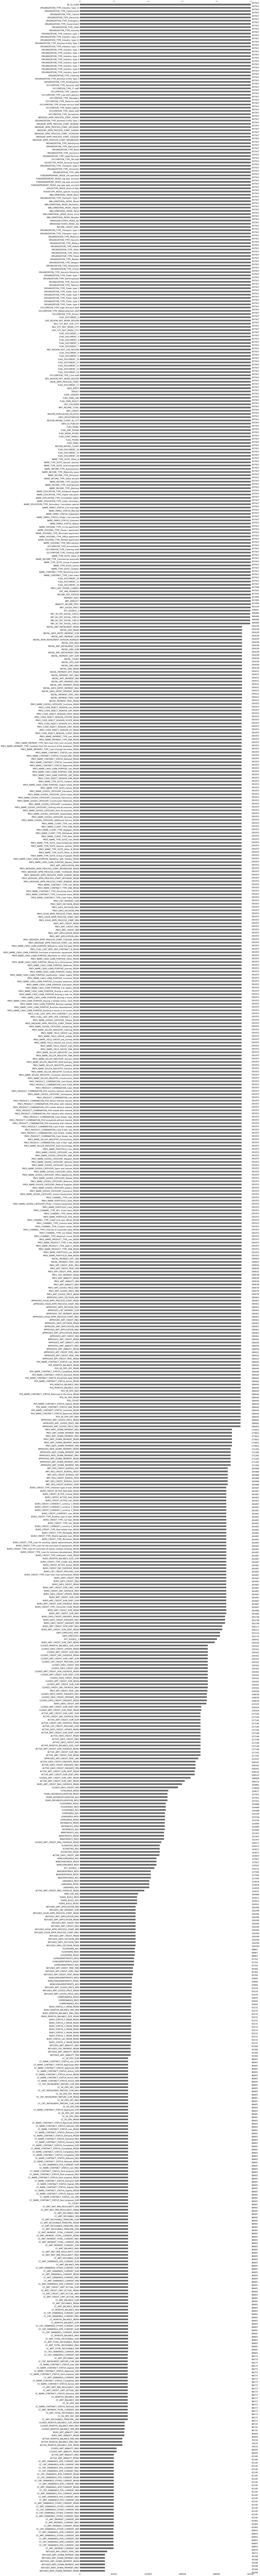

In [9]:
%matplotlib inline
msno.bar(train_df,sort="ascending")

In [9]:
# Train missing values (in percent)
train_missing = (train_df.isnull().sum() / len(train_df)).sort_values(ascending = False)
train_missing

REFUSED_AMT_DOWN_PAYMENT_MAX                                             0.853116
REFUSED_AMT_DOWN_PAYMENT_MEAN                                            0.853116
REFUSED_AMT_DOWN_PAYMENT_MIN                                             0.853116
REFUSED_RATE_DOWN_PAYMENT_MEAN                                           0.853116
REFUSED_RATE_DOWN_PAYMENT_MAX                                            0.853116
REFUSED_RATE_DOWN_PAYMENT_MIN                                            0.853116
REFUSED_APP_CREDIT_PERC_VAR                                              0.840143
CC_AMT_PAYMENT_CURRENT_VAR                                               0.802870
CC_CNT_DRAWINGS_POS_CURRENT_VAR                                          0.802629
CC_AMT_DRAWINGS_OTHER_CURRENT_VAR                                        0.802629
CC_CNT_DRAWINGS_OTHER_CURRENT_VAR                                        0.802629
CC_AMT_DRAWINGS_POS_CURRENT_VAR                                          0.802629
CC_CNT_DRAWINGS_

In [10]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
all_missing = list(set(train_missing))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

There are 42 columns with more than 75% missing values


In [12]:
train_df = train_df.drop(columns = all_missing)
train_df_ = train_df_.drop(columns = all_missing)

In [13]:
train_df.shape

(307507, 755)

In [14]:
train_df_.shape

(10000, 755)

# Suppression des variables corrélées

Les variables colinéaires sont celles qui sont fortement corrélées les unes avec les autres. Elles peuvent diminuer la capacité du modèle à apprendre, réduire son interprétabilité et diminuer ses performances de généralisation sur l'ensemble de test. Évidemment, ce sont trois choses que nous voulons augmenter, donc la suppression des variables colinéaires est une étape utile. Nous allons établir un seuil arbitraire pour la suppression des variables colinéaires, puis supprimer l'une des variables de chaque paire qui dépasse ce seuil.

Le code ci-dessous identifie les variables fortement corrélées sur la base du coefficient de corrélation de Pearson étant supérieure à **0,9**. Encore une fois, cela n'est pas entièrement précis puisque nous traitons une section limitée des données. Ce code est à des fins d'illustration, mais s'il était utilisé avec l'ensemble de données complet (si les noyaux le permettaient), il fonctionnerait!

In [15]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train_df.corr().abs()
corr_matrix.head()

SK_ID_CURR    TARGET  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR         1.000000  0.002111     0.000735      0.001215   
TARGET             0.002111  1.000000     0.054710      0.021850   
CODE_GENDER        0.000735  0.054710     1.000000      0.345848   
FLAG_OWN_CAR       0.001215  0.021850     0.345848      1.000000   
FLAG_OWN_REALTY    0.000710  0.006146     0.044374      0.002820   

                 FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR              0.000710      0.001120          0.001821    0.000350   
TARGET                  0.006146      0.019189          0.003982    0.030371   
CODE_GENDER             0.044374      0.047387          0.074730    0.021597   
FLAG_OWN_CAR            0.002820      0.102037          0.083381    0.116226   
FLAG_OWN_REALTY         1.000000      0.002370          0.002934    0.039266   

                 AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR          0.000440         0.000241                    0.000852   
TARGET              0.012818         0.039647                    0.037225   
CODE_GENDER         0.076990         0.022512                    0.014055   
FLAG_OWN_CAR        0.141589         0.120306                    0.041313   
FLAG_OWN_REALTY     0.005221         0.045535                    0.015170   

                 DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
SK_ID_CURR         0.001500       0.000101           0.000973   
TARGET             0.078242       0.074957           0.041976   
CODE_GENDER        0.148067       0.092562           0.077187   
FLAG_OWN_CAR       0.129883       0.023114           0.087778   
FLAG_OWN_REALTY    0.119152       0.030658           0.025226   

                 DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR              0.000389     0.001821    0.002804        0.001332   
TARGET                  0.051457     0.037611    0.000534        0.045984   
CODE_GENDER             0.000132     0.006253    0.002503        0.157245   
FLAG_OWN_CAR            0.013661          NaN    0.002512        0.154659   
FLAG_OWN_REALTY         0.006664     0.001497    0.001198        0.070026   

                 FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR              0.000395          0.002815    0.002769    0.000278   
TARGET                  0.028533          0.000370    0.023801    0.001759   
CODE_GENDER             0.033942          0.006020    0.019503    0.018231   
FLAG_OWN_CAR            0.011463          0.006644    0.007595    0.032106   
FLAG_OWN_REALTY         0.114064          0.008526    0.041521    0.029249   

                 CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR              0.002885              0.001067   
TARGET                  0.009310              0.058901   
CODE_GENDER             0.080551              0.017881   
FLAG_OWN_CAR            0.149912              0.022676   
FLAG_OWN_REALTY         0.007345              0.001285   

                 REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                          0.001130                 0.000354   
TARGET                              0.060895                 0.024164   
CODE_GENDER                         0.017284                 0.007151   
FLAG_OWN_CAR                        0.021414                 0.014373   
FLAG_OWN_REALTY                     0.001880                 0.102693   

                 REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                         0.000284                    0.001095   
TARGET                             0.005575                    0.006941   
CODE_GENDER                        0.023690                    0.103456   
FLAG_OWN_CAR                       0.000667                    0.038938   
FLAG_OWN_REALTY                    0.036300                    0.032314   

                 LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                    

In [16]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
upper.head()

SK_ID_CURR    TARGET  CODE_GENDER  FLAG_OWN_CAR  \
SK_ID_CURR              NaN  0.002111     0.000735      0.001215   
TARGET                  NaN       NaN     0.054710      0.021850   
CODE_GENDER             NaN       NaN          NaN      0.345848   
FLAG_OWN_CAR            NaN       NaN          NaN           NaN   
FLAG_OWN_REALTY         NaN       NaN          NaN           NaN   

                 FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR              0.000710      0.001120          0.001821    0.000350   
TARGET                  0.006146      0.019189          0.003982    0.030371   
CODE_GENDER             0.044374      0.047387          0.074730    0.021597   
FLAG_OWN_CAR            0.002820      0.102037          0.083381    0.116226   
FLAG_OWN_REALTY              NaN      0.002370          0.002934    0.039266   

                 AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
SK_ID_CURR          0.000440         0.000241                    0.000852   
TARGET              0.012818         0.039647                    0.037225   
CODE_GENDER         0.076990         0.022512                    0.014055   
FLAG_OWN_CAR        0.141589         0.120306                    0.041313   
FLAG_OWN_REALTY     0.005221         0.045535                    0.015170   

                 DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
SK_ID_CURR         0.001500       0.000101           0.000973   
TARGET             0.078242       0.074957           0.041976   
CODE_GENDER        0.148067       0.092562           0.077187   
FLAG_OWN_CAR       0.129883       0.023114           0.087778   
FLAG_OWN_REALTY    0.119152       0.030658           0.025226   

                 DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR              0.000389     0.001821    0.002804        0.001332   
TARGET                  0.051457     0.037611    0.000534        0.045984   
CODE_GENDER             0.000132     0.006253    0.002503        0.157245   
FLAG_OWN_CAR            0.013661          NaN    0.002512        0.154659   
FLAG_OWN_REALTY         0.006664     0.001497    0.001198        0.070026   

                 FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR              0.000395          0.002815    0.002769    0.000278   
TARGET                  0.028533          0.000370    0.023801    0.001759   
CODE_GENDER             0.033942          0.006020    0.019503    0.018231   
FLAG_OWN_CAR            0.011463          0.006644    0.007595    0.032106   
FLAG_OWN_REALTY         0.114064          0.008526    0.041521    0.029249   

                 CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR              0.002885              0.001067   
TARGET                  0.009310              0.058901   
CODE_GENDER             0.080551              0.017881   
FLAG_OWN_CAR            0.149912              0.022676   
FLAG_OWN_REALTY         0.007345              0.001285   

                 REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
SK_ID_CURR                          0.001130                 0.000354   
TARGET                              0.060895                 0.024164   
CODE_GENDER                         0.017284                 0.007151   
FLAG_OWN_CAR                        0.021414                 0.014373   
FLAG_OWN_REALTY                     0.001880                 0.102693   

                 REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
SK_ID_CURR                         0.000284                    0.001095   
TARGET                             0.005575                    0.006941   
CODE_GENDER                        0.023690                    0.103456   
FLAG_OWN_CAR                       0.000667                    0.038938   
FLAG_OWN_REALTY                    0.036300                    0.032314   

                 LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
SK_ID_CURR                    

In [17]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 166 columns to remove.


In [18]:
train_df = train_df.drop(columns = to_drop)

In [19]:
train_df_ = train_df_.drop(columns = to_drop)

In [20]:
train_df.shape

(307507, 589)

In [21]:
train_df_.shape

(10000, 589)

In [22]:
#train_df.to_csv("data/traited/df_train_corr.csv")

# Sélection des variables selon leur importance

La prochaine méthode que nous pouvons utiliser pour la sélection des variables est d'utiliser l'importance de ces variable à partir d'un modèle. Les modèles basés sur les arbres peuvent déterminer une "importance" pour chaque variable en mesurant la réduction de l'impureté en incluant la variable dans le modèle. La valeur relative des importances peut être utilisée comme une approximation de la "pertinence" des différentes variables dans un modèle.Nous pouvons donc utiliser les importances affectées pour supprimer les variables que le modèle ne considère pas comme importantes.

Une méthode pour le faire automatiquement est la méthode **Recursive Feature Elimination** dans Scikit-Learn. Elle accepte un estimateur (qui renvoie soit les poids des variables comme une régression linéaire, soit les importances des variables comme une forêt aléatoire) et un nombre souhaité de variables. En ajustant le modèle plusieurs fois sur les données et en supprimant itérativement les variables les moins importantes, on obtient le nombre souhaité de variables restantes. Cela signifie que nous avons un autre hyperparamètre arbitraire à utiliser dans notre pipeline : le nombre de variables à conserver !

Au lieu de le faire automatiquement, nous pouvons effectuer notre propre suppression de variables en commençant par supprimer toutes les variables d'importance nulle du modèle. Si cela laisse trop de variables, nous pouvons alors envisager de supprimer les variables ayant les importances les plus faibles. Nous utiliserons un modèle Gradient Boosted de la bibliothèque LightGBM pour évaluer les importances des variables. Si vous êtes habitué à la bibliothèque Scikit-Learn, la bibliothèque LightGBM a une API qui rend le déploiement du modèle très similaire à l'utilisation d'un modèle Scikit-Learn.

Puisque le modèle LightGBM n'a pas besoin que les valeurs manquantes soient imputées, nous pouvons l'ajuster directement sur les données d'entraînement. Nous utiliserons l'arrêt anticipé (Early Stopping) pour déterminer le nombre optimal d'itérations et exécuterons le modèle deux fois, en faisant la moyenne des importances des variables pour essayer d'éviter le surajustement à un certain ensemble de caractéristiques.

In [24]:
train_labels = train_df["TARGET"]
train_ids = train_df['SK_ID_CURR']
train_df = train_df.drop(columns = ['TARGET', 'SK_ID_CURR'])
train_labels_ = train_df_["TARGET"]
train_ids_ = train_df_['SK_ID_CURR']
train_df_ = train_df_.drop(columns = ['TARGET', 'SK_ID_CURR'])

In [25]:
train_df_ = train_df_.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df = train_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [26]:
print(train_df.shape)
print(train_df_.shape)

(307507, 587)
(10000, 587)


In [98]:
train_df.head()

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  \
0            0             0                0             0          202500.0   
1            1             0                1             0          270000.0   
2            0             1                0             0           67500.0   
3            1             0                0             0          135000.0   
4            0             0                0             0          121500.0   

   AMT_CREDIT  AMT_ANNUITY  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0    406597.5      24700.5                    0.018801       -9461   
1   1293502.5      35698.5                    0.003541      -16765   
2    135000.0       6750.0                    0.010032      -19046   
3    312682.5      29686.5                    0.008019      -19005   
4    513000.0      21865.5                    0.028663      -19932   

   DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
0         -637.0            -3648.0            -2120          NaN           1   
1        -1188.0            -1186.0             -291          NaN           1   
2         -225.0            -4260.0            -2531         26.0           1   
3        -3039.0            -9833.0            -2437          NaN           1   
4        -3038.0            -4311.0            -3458          NaN           1   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           1           0   
1               1                0                 1           1           0   
2               1                1                 1           1           0   
3               1                0                 1           0           0   
4               1                0                 1           0           0   

   CNT_FAM_MEMBERS  REGION_RATING_CLIENT  HOUR_APPR_PROCESS_START  \
0              1.0                     2                       10   
1              2.0                     1                       11   
2              1.0                     2                        9   
3              2.0                     2                       17   
4              1.0                     2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.262949      0.139376          0.0247            0.0369   
1      0.622246           NaN          0.0959            0.0529   
2      0.555912      0.729567             NaN               NaN   
3      0.650442           NaN             NaN               NaN   
4      0.322738           NaN             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960   

In [28]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train_df.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type='goss', n_estimators=10000, class_weight='balanced')

In [29]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train_df, train_labels, test_size=0.25, random_state=i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', callbacks=[lgb.early_stopping(200),
                           lgb.callback.log_evaluation(200)])
    
    # Record the feature importances
    feature_importances += model.feature_importances_

C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.789164	valid_0's binary_logloss: 0.505167


C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.784395	valid_0's binary_logloss: 0.504561


In [30]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train_df_.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

feature  importance
28   EXT_SOURCE_1       147.5
205  PAYMENT_RATE       142.0
29   EXT_SOURCE_2       134.5
30   EXT_SOURCE_3       120.0
8      DAYS_BIRTH        88.0

In [31]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 186 features with 0.0 importance


feature  importance
150                  ORGANIZATION_TYPE_Industrytype3         0.0
407  PREV_NAME_GOODS_CATEGORY_HouseConstruction_MEAN         0.0
408          PREV_NAME_GOODS_CATEGORY_Insurance_MEAN         0.0
409            PREV_NAME_GOODS_CATEGORY_Jewelry_MEAN         0.0
586                  CC_NAME_CONTRACT_STATUS_nan_VAR         0.0

In [32]:
feature_importances.head(5)

feature  importance
28   EXT_SOURCE_1       147.5
205  PAYMENT_RATE       142.0
29   EXT_SOURCE_2       134.5
30   EXT_SOURCE_3       120.0
8      DAYS_BIRTH        88.0

Il semble également que bon nombre des caractéristiques que nous avons créées aient une importance littéralement égale à 0. Pour la machine à gradient boosting, les caractéristiques ayant une importance de 0 ne sont pas du tout utilisées pour effectuer des divisions. Par conséquent, nous pouvons supprimer ces caractéristiques du modèle sans effet sur les performances (à part accélérer l'entraînement).

In [33]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', callbacks=[lgb.early_stopping(200), lgb.callback.log_evaluation(200)])
        valid_y_pred = model.predict_proba(valid_features)[:, 1]
        print("aloo")
        print("%.4f", roc_auc_score(valid_y, valid_y_pred))
        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [34]:
first_round_zero_features, feature_importances = identify_zero_importance_features(train_df, train_labels)

C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.789164	valid_0's binary_logloss: 0.505167
aloo
%.4f 0.7898431718266448


C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.784395	valid_0's binary_logloss: 0.504561
aloo
%.4f 0.7851428955160781

There are 186 features with 0.0 importance


In [35]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

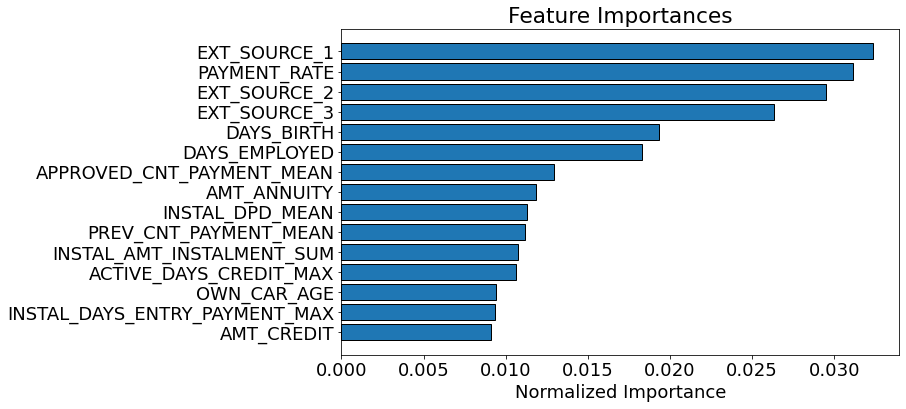

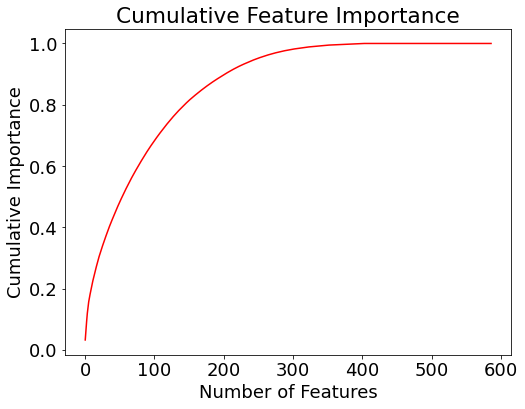

203 features required for 0.90 of cumulative importance


In [36]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [37]:
train_df = train_df.drop(columns = zero_features)
train_df_ = train_df_.drop(columns = zero_features)

In [38]:
print('Training shape: ', train_df.shape)
print('Training shape red: ', train_df_.shape)

Training shape:  (307507, 401)
Training shape red:  (10000, 401)


In [39]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train_df, train_labels)

C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.789464	valid_0's binary_logloss: 0.505541
aloo
%.4f 0.7898431718266448


C:\Users\rimla\AppData\Roaming\Python\Python39\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.784923	valid_0's binary_logloss: 0.504526
aloo
%.4f 0.7851428955160781

There are 0 features with 0.0 importance


Il ne reste désormais aucune variable d'importance nulle (nous aurions dû nous y attendre). Si nous voulons supprimer davantage de variables, nous devrons commencer par celles qui ont une importance non nulle. Une façon de le faire pourrait être de conserver suffisamment de variables pour représenter un pourcentage seuil d'importance, comme 95%. À ce stade, conservons suffisamment de variables pour représenter 95% de l'importance. Encore une fois, il s'agit d'une décision arbitraire !

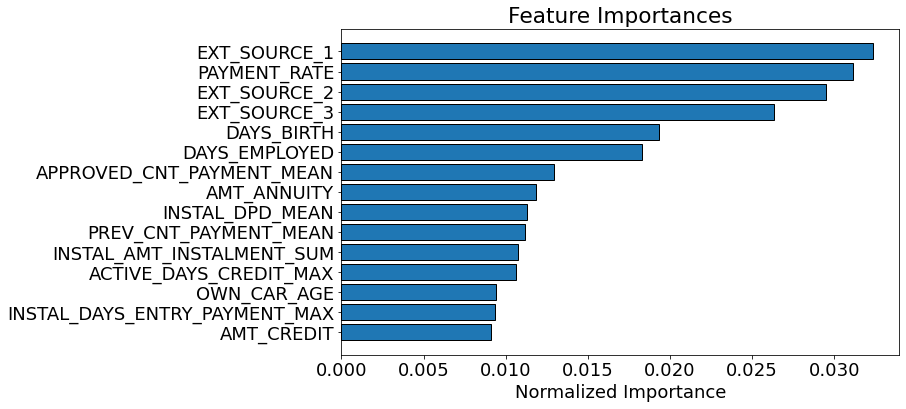

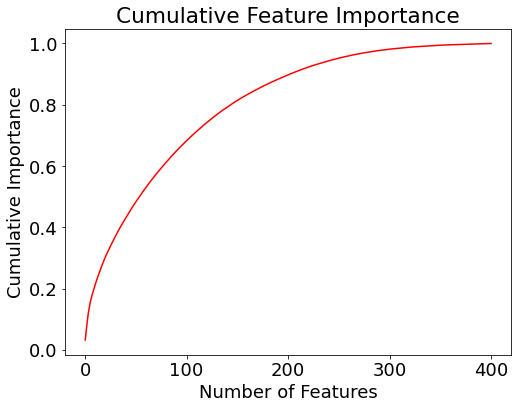

249 features required for 0.95 of cumulative importance


In [40]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

Nous pouvons ne conserver que les variables nécessaires pour atteindre 95% d'importance. Cette étape semble avoir le plus de chances de nuire à la capacité d'apprentissage du modèle, donc plutôt que de modifier l'ensemble de données original, nous allons créer des copies plus petites. Ensuite, nous pouvons tester les deux versions des données pour voir si l'étape de suppression des variables supplémentaires en vaut la peine.

In [41]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_df_small = train_df[features_to_keep]
train_df_small_ = train_df_[features_to_keep]

In [42]:
train_df_small['TARGET'] = train_labels
train_df_small['SK_ID_CURR'] = train_ids

train_df_small.to_csv('data/traited/df_train_corr_import_small.csv', index = False)

C:\Users\rimla\AppData\Local\Temp\ipykernel_10500\1860549392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_small['TARGET'] = train_labels
C:\Users\rimla\AppData\Local\Temp\ipykernel_10500\1860549392.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_small['SK_ID_CURR'] = train_ids


In [43]:
df = train_df.copy()
df['TARGET'] = train_labels
df['SK_ID_CURR'] = train_ids

df.to_csv('data/traited/df_train_corr_import.csv', index = False)

In [44]:
del df

# Test New Featuresets

In [51]:
# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    #test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}".format(train_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    #sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            #nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            verbose=-1, )

        clf.fit(train_x, train_y,
                eval_set=[(train_x, train_y), (valid_x, valid_y)], 
                eval_metric= 'auc',
                callbacks=[lgb.callback.early_stopping(stopping_rounds=200),
                           lgb.callback.log_evaluation(200)])

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        #sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.4f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), sep='')
        print("\n")
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.4f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances02png')

## Test "Full" Dataset

In [53]:
print(train_df.shape)

(307507, 403)


Starting LightGBM. Train shape: (307507, 403)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.79587	training's binary_logloss: 0.235311	valid_1's auc: 0.77598	valid_1's binary_logloss: 0.246947
[400]	training's auc: 0.817992	training's binary_logloss: 0.22591	valid_1's auc: 0.786558	valid_1's binary_logloss: 0.242841
[600]	training's auc: 0.832743	training's binary_logloss: 0.219884	valid_1's auc: 0.790688	valid_1's binary_logloss: 0.241375
[800]	training's auc: 0.844536	training's binary_logloss: 0.215026	valid_1's auc: 0.792391	valid_1's binary_logloss: 0.240813
[1000]	training's auc: 0.85504	training's binary_logloss: 0.210632	valid_1's auc: 0.793719	valid_1's binary_logloss: 0.240397
[1200]	training's auc: 0.864809	training's binary_logloss: 0.206437	valid_1's auc: 0.793999	valid_1's binary_logloss: 0.240285
[1400]	training's auc: 0.873862	training's binary_logloss: 0.202518	valid_1's auc: 0.794254	valid_1's binary_logloss: 0.240226
Early stopp

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.796107	training's binary_logloss: 0.235534	valid_1's auc: 0.769783	valid_1's binary_logloss: 0.245581
[400]	training's auc: 0.818213	training's binary_logloss: 0.226147	valid_1's auc: 0.780763	valid_1's binary_logloss: 0.241382
[600]	training's auc: 0.832717	training's binary_logloss: 0.220184	valid_1's auc: 0.785202	valid_1's binary_logloss: 0.239813
[800]	training's auc: 0.844429	training's binary_logloss: 0.21536	valid_1's auc: 0.787104	valid_1's binary_logloss: 0.239199
[1000]	training's auc: 0.854957	training's binary_logloss: 0.210973	valid_1's auc: 0.788075	valid_1's binary_logloss: 0.238851
[1200]	training's auc: 0.864625	training's binary_logloss: 0.206792	valid_1's auc: 0.789101	valid_1's binary_logloss: 0.238529
[1400]	training's auc: 0.873516	training's binary_logloss: 0.202833	valid_1's auc: 0.789704	valid_1's binary_logloss: 0.238333
[1600]	training's auc: 0.88157	training's binary_loglo

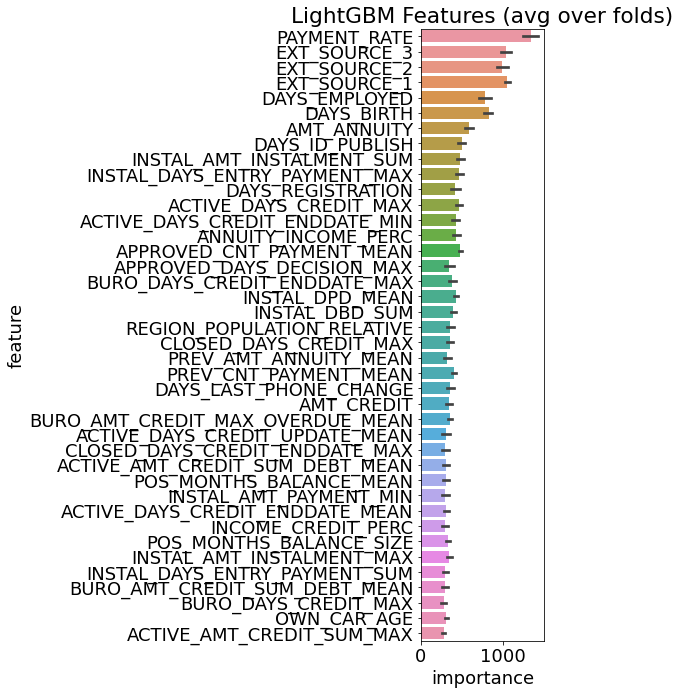

In [52]:
train_df['TARGET'] = train_labels
train_df['SK_ID_CURR'] = train_ids
feat_importance = kfold_lightgbm(train_df, num_folds=10)

The full features after feature selection score **0.7915**. 

## test "Small" Dataset

The small dataset requires one additional step over the ful l dataset:

Keep only features needed to reach **95%** cumulative importance in the gradient boosting machine

In [55]:
print(train_df_small.shape)

(307507, 250)


Starting LightGBM. Train shape: (307507, 250)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.795692	training's binary_logloss: 0.235367	valid_1's auc: 0.775327	valid_1's binary_logloss: 0.247077
[400]	training's auc: 0.817766	training's binary_logloss: 0.225964	valid_1's auc: 0.785485	valid_1's binary_logloss: 0.243086
[600]	training's auc: 0.832551	training's binary_logloss: 0.219945	valid_1's auc: 0.789233	valid_1's binary_logloss: 0.241789
[800]	training's auc: 0.844685	training's binary_logloss: 0.21498	valid_1's auc: 0.790891	valid_1's binary_logloss: 0.241255
[1000]	training's auc: 0.85525	training's binary_logloss: 0.210566	valid_1's auc: 0.791664	valid_1's binary_logloss: 0.241044
[1200]	training's auc: 0.865012	training's binary_logloss: 0.206396	valid_1's auc: 0.791948	valid_1's binary_logloss: 0.240952
[1400]	training's auc: 0.874086	training's binary_logloss: 0.202415	valid_1's auc: 0.792022	valid_1's binary_logloss: 0.240942
Early sto

[600]	training's auc: 0.832411	training's binary_logloss: 0.220261	valid_1's auc: 0.785138	valid_1's binary_logloss: 0.239917
[800]	training's auc: 0.844278	training's binary_logloss: 0.215354	valid_1's auc: 0.787253	valid_1's binary_logloss: 0.239244
[1000]	training's auc: 0.854694	training's binary_logloss: 0.210993	valid_1's auc: 0.788262	valid_1's binary_logloss: 0.238896
[1200]	training's auc: 0.864261	training's binary_logloss: 0.206895	valid_1's auc: 0.788843	valid_1's binary_logloss: 0.238711
[1400]	training's auc: 0.873233	training's binary_logloss: 0.202908	valid_1's auc: 0.789471	valid_1's binary_logloss: 0.238495
[1600]	training's auc: 0.88121	training's binary_logloss: 0.199276	valid_1's auc: 0.789818	valid_1's binary_logloss: 0.238403
[1800]	training's auc: 0.888645	training's binary_logloss: 0.195717	valid_1's auc: 0.790025	valid_1's binary_logloss: 0.238335
[2000]	training's auc: 0.895616	training's binary_logloss: 0.192242	valid_1's auc: 0.790156	valid_1's binary_loglo

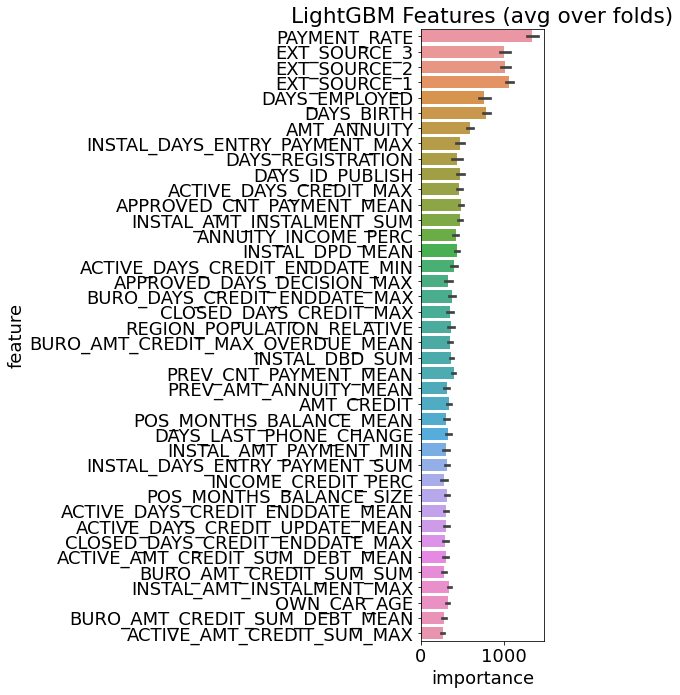

In [56]:
feat_importance = kfold_lightgbm(train_df_small, num_folds=10)

The smaller featureset scores **0.7904**

# Autres options pour la réduction de dimension

Nous n'avons couvert qu'une petite partie des techniques utilisées pour la sélection des variables/réduction de la dimensionnalité. Il existe de nombreuses autres méthodes telles que :

* PCA : Analyse en Composantes Principales (PCA en anglais)
* ICA : Analyse en Composantes Indépendantes (ICA en anglais)
* Apprentissage de variétés : également appelé réduction de la dimensionnalité non linéaire (manifold learning)

La PCA est une excellente méthode pour réduire le nombre de variables, à condition que vous ne vous préoccupiez pas de l'interprétabilité du modèle. Elle projette l'ensemble original de caractéristiques dans une dimension inférieure, éliminant ainsi toute représentation physique derrière les variables. La PCA suppose également que les données sont distribuées selon une loi normale, ce qui peut ne pas être le cas, notamment lorsqu'on traite des données générées par des humains dans le monde réel.

Les représentations de l'ICA obscurcissent également toute signification physique derrière les variables et préservent les dimensions les plus "indépendantes" des données (ce qui est différent des dimensions avec la plus grande variance).

L'apprentissage de variétés (manifold learning) est plus souvent utilisé pour des visualisations en basse dimension (comme avec T-SNE ou LLE) plutôt que pour la réduction de la dimensionnalité pour un classifieur. Ces méthodes dépendent fortement de plusieurs hyperparamètres et ne sont pas déterministes, ce qui signifie qu'il n'y a aucun moyen de les appliquer à de nouvelles données (en d'autres termes, vous ne pouvez pas les ajuster `fit` aux données d'entraînement et ensuite transformer `transform` séparément les données de test). La représentation apprise d'un ensemble de données changera à chaque fois que vous appliquez l'apprentissage de variétés (manifold learning), ce qui en fait généralement une méthode instable pour la sélection des variables.

## PCA exemple

Nous pouvons passer par un exemple rapide pour montrer comment la PCA est mise en œuvre. Sans entrer dans trop de détails, la PCA trouve un nouvel ensemble d'axes (les composantes principales) qui maximisent la quantité de variance capturée dans les données. Les données d'origine sont ensuite projetées sur ces composantes principales. L'idée est que nous pouvons utiliser moins de composantes principales que le nombre original de variables tout en capturant la plupart de la variance. La PCA est mise en œuvre dans Scikit-Learn de la même manière que les méthodes de prétraitement. Nous pouvons soit sélectionner le nombre de nouvelles composantes, soit la fraction de variance que nous voulons expliquer dans les données. Si nous ne passons aucun argument, le nombre de composantes principales sera le même que le nombre de variables d'origine. Nous pouvons ensuite utiliser la variable `variance_explained_ratio_` pour déterminer le nombre de composantes nécessaires pour différents seuils de variance conservée.

In [57]:
print(train_df_small.shape)

(307507, 250)


In [70]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

train = train_df_small.copy()

# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
#test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),  # median
             ('pca', PCA())])

# Fit and transform on the training data
train.replace([np.inf, -np.inf], np.nan, inplace=True)
train_pca = pipeline.fit_transform(train)

# transform the testing data
#test_pca = pipeline.transform(test)

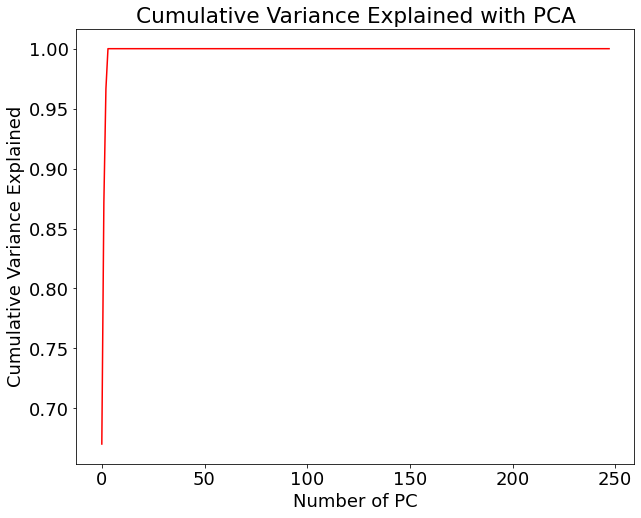

In [71]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

Nous n'avons besoin que de quelques composantes principales pour rendre compte de la majorité de la variance dans les données. Nous pouvons utiliser les deux premières composantes principales pour visualiser l'ensemble du jeu de données. Nous allons colorer les points de données en fonction de la valeur de la cible pour voir si l'utilisation de deux composantes principales sépare clairement les classes.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


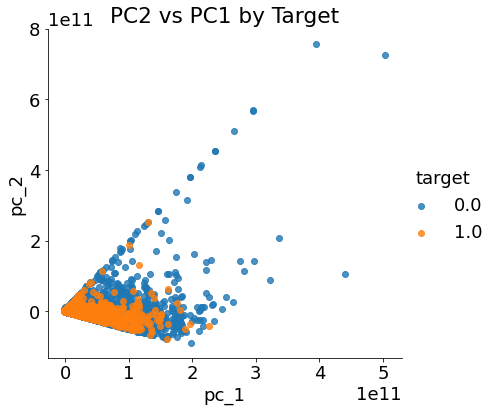

In [74]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 6)
plt.title('PC2 vs PC1 by Target');

In [73]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))

2 principal components account for 87.1565% of the variance.


Même si nous avons pris en compte la plupart de la variance, cela ne signifie pas que la décomposition PCA rende plus facile la tâche d'identifier les prêts remboursés et ceux qui ne le seront pas. PCA ne prend pas en compte la valeur de l'étiquette lors de la projection des caractéristiques dans une dimension inférieure. 

# Conclusion

Dans ce notebook, nous avons utilisé plusieurs méthodes de sélection de variables. Ces méthodes sont nécessaires pour réduire le nombre de variables afin d'augmenter l'interprétabilité du modèle, diminuer le temps d'exécution du modèle et améliorer les performances de généralisation sur l'ensemble de test. Les méthodes de sélection de variables que nous avons utilisées sont :

* Supprimer les variables hautement corrélées, mesurées par un coefficient de corrélation supérieur à 0,9.
* Supprimer les colonnes avec plus de 75 % de valeurs manquantes.
* Supprimer les variables ayant une importance nulle, déterminée par une machine de boosting de gradient.
* Ne conserver que suffisamment de variables pour rendre compte de 95 % de l'importance dans la machine de boosting de gradient.

En utilisant les méthodes précédentes, nous avons réduit le nombre de variables de 797 à **250** avec un score AUC ROC de validation croisée (cv=10) de **0.7904**.